# Predicting the rating a reviewer will give a restaurant using Featuretools and the nlp-primitives library

<a style="margin:30px" href="https://www.featuretools.com">
    <img width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
</a>

**When customers visit restaurants, they will oftentimes leave a review of some sort. Using data from TripAdvisor, we investigate how this text data can be used to predict the overall thoughts of the customer on that restuarant represented in a star rating.**

In this tutorial, we show how [Featuretools](https://www.featuretools.com) can be used alongside the [nlp-primitives](https://github.com/FeatureLabs/nlp_primitives) library to train an accurate machine learning model that can predict a customer's rating of a restaurant based on the text of their review and some information about the restaurant.

*Note: If you are running this notebook yourself, refer to the [readme](https://github.com/FeatureLabs/predict-restaurant-rating/blob/master/README.md) on Github for instructions to download the dataset*

## Highlights

* We use the nlp-primitives library to create structured data from unstructured, hard to parse, textual data
* We acheive an accuracy rating 40% higher than the baseline
* We use these primitives alongside Featuretools' `dfs` method to create as much information as possible from a dataset containing only two entities.
* The `dfs` method stacks the default primitives on top of the nlp-primitives to create new, data-rich, features.
* We build a pipeline that it can be reused for numerous NLP prediction problems (You can try this yourself!)

In [1]:
import nltk
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nlp_primitives
import featuretools as ft
import featuretools.variable_types as vtypes
import seaborn as sns
import sklearn
import numpy as np
import helpers

from featuretools.primitives import *
from nlp_primitives import (
    DiversityScore,
    LSA,
    MeanCharactersPerWord,
    PartOfSpeechCount,
    PolarityScore, 
    PunctuationCount,
    StopwordCount,
    TitleWordCount,
    UniversalSentenceEncoder,
    UpperCaseCount)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier

print('Featuretools version {}'.format(ft.__version__))

Featuretools version 0.10.0


## Step 1. Load Data
We start by loading in the data from our machine. This data is from a kaggle dataset, and instuctions on how to download it and can be found in the read me on github. Once it has been downloaded, rename the file `reviews.json`, and ensure that it is in the `predict-restaurant-rating` folder. This data includes two entity sets: The restaurants entityset, which includes the name, address, price, star-rating, and several other pieces of information about each restaurant in the data, and the reviews entityset, which includes the title of the review, date of the review, and text of the review.

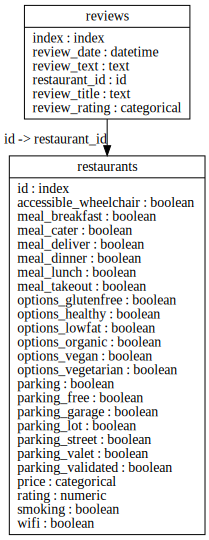

In [2]:
es = helpers.file_to_es('./reviews.json')
es.plot()

### Visualize Data Distribution
This is a multiclass classification problem, and we can see here that the data is skewed towards higher reviews, but that there are reviews in every category, from 1-5 stars.

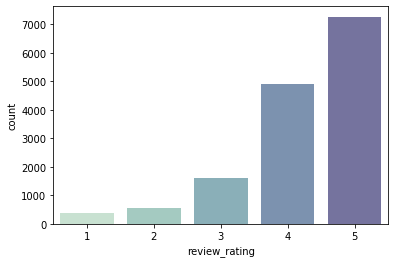

In [3]:
df = es['reviews'].df

col = sns.color_palette("Blues")
sns.countplot(x=df['review_rating'], palette = sns.cubehelix_palette(8, start=1, rot=-.75))

## Step 2. Compare Against Baseline
In order to see how much of an effect these primitives have, we will first create a baseline, and then compare the accuracy of the two models.

In [4]:
rating_df = es['reviews'].df[['index', 'review_rating']]
ignore = {'restaurants': ['rating'],
          'reviews': ['review_rating']}

baseline_features = ft.dfs(entityset=es,
                  target_entity='reviews',
                  verbose=True,
                  features_only=True,
                  ignore_variables=ignore)

baseline_feature_matrix = ft.calculate_feature_matrix(features=baseline_features,
                                                      entityset=es,
                                                      verbose=True)

baseline_fm = baseline_feature_matrix.reindex(rating_df.index)

y = rating_df['review_rating']

baseline_train_fm, baseline_test_fm, baseline_y_train, baseline_y_test = train_test_split(baseline_fm, y, test_size=0.15, stratify=y)

Built 33 features
Elapsed: 00:00 | Progress: 100%|██████████


In [5]:
base_rfc = RandomForestClassifier(n_estimators=100, class_weight = "balanced", n_jobs=-1)
base_rfc.fit(baseline_train_fm, baseline_y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

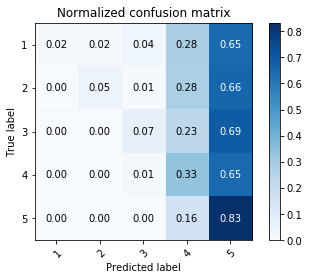

In [6]:
helpers.plot_confusion_matrix(baseline_y_test, 
                      base_rfc.predict(baseline_test_fm), 
                      ['1', '2', '3', '4', '5'])

This baseline has an accuracy of about 50%, with most of the samples being classified as a 5, the most common class. This accuracy comes from classifying most reviews as a 4 or a 5, the two most common categories, so it is clear that this model's accuracy only comes from guessing the most common classes and getting it right only due to the frequency of those categories.

## Step 3. Create Feature Matrix
Here we choose the features we wish to include in the training (in this case all of them), and calculate the training feature matrix. We add some transformation primitives, but this dfs will also include many default primitive functions to create features, and setting the `max_depth=4` will ensure that these nlp-primitives create features that other features then stack on.

In [7]:
trans = [DiversityScore,
         LSA,
         MeanCharactersPerWord,
         PartOfSpeechCount,
         PolarityScore, 
         PunctuationCount,
         StopwordCount,
         TitleWordCount,
         UniversalSentenceEncoder,
         UpperCaseCount]

ignore = {'restaurants': ['rating'],
          'reviews': ['review_rating']}
drop_contains = ['(reviews.UNIVERSAL']

features = ft.dfs(entityset=es,
                  target_entity='reviews',
                  trans_primitives=trans,
                  verbose=True,
                  features_only=True,
                  ignore_variables=ignore,
                  drop_contains=drop_contains,
                  max_depth=4)

Built 333 features


This `dfs` call created 333 features, which is about 10 times more features than in the baseline. Now, we will calculate these features.

In [8]:
feature_matrix = ft.calculate_feature_matrix(features=features,
                                             entityset=es,
                                             verbose=True)

Elapsed: 09:57 | Progress: 100%|██████████


In [9]:
features[0:10]

[<Feature: restaurant_id>,
 <Feature: DIVERSITY_SCORE(review_text)>,
 <Feature: DIVERSITY_SCORE(review_title)>,
 <Feature: LSA(review_text)>,
 <Feature: LSA(review_title)>,
 <Feature: MEAN_CHARACTERS_PER_WORD(review_text)>,
 <Feature: MEAN_CHARACTERS_PER_WORD(review_title)>,
 <Feature: PART_OF_SPEECH_COUNT(review_text)>,
 <Feature: PART_OF_SPEECH_COUNT(review_title)>,
 <Feature: POLARITY_SCORE(review_text)>]

## Step 4. Dividing the data
We must do two things in this step: split the data into a training set and a testing set, and separate the labels from the feature matrix. We will use the train_test_split functionality of sklearn to do this.

In [10]:
feature_matrix = feature_matrix.reindex(rating_df.index)

In [11]:
y = rating_df['review_rating']

train_feature_matrix, test_feature_matrix, y_train, y_test = train_test_split(feature_matrix, y, test_size=0.15, stratify=y)

## Step 5. Machine Learning
Here we create and test various machine learning models from sklearn using the feature matrix.

In [12]:
lgr = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=200)
lgr.fit(train_feature_matrix, y_train)
lgr.score(test_feature_matrix, y_test)

0.6385487528344671

In [13]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(train_feature_matrix, y_train)
hgbc.score(test_feature_matrix, y_test)

0.6825396825396826

In [14]:
rfc = RandomForestClassifier(n_estimators=100, class_weight = "balanced", n_jobs=-1)
rfc.fit(train_feature_matrix, y_train)
rfc.score(test_feature_matrix, y_test)

0.636281179138322

Here we can observe the feature importances for this model, and see that the Universal Sentence Encoder features and the polarity score are the most influential in this model.

In [15]:
headers = ["name", "score"]
values = pd.DataFrame(sorted(zip(train_feature_matrix.columns, rfc.feature_importances_), key=lambda x: x[1] * -1))

values.head(10)

,0,1
0,UNIVERSAL_SENTENCE_ENCODER(review_text)[415],0.012748
1,UNIVERSAL_SENTENCE_ENCODER(review_title)[415],0.012526
2,POLARITY_SCORE(review_text),0.011117
3,UNIVERSAL_SENTENCE_ENCODER(review_text)[289],0.009263
4,UNIVERSAL_SENTENCE_ENCODER(review_text)[28],0.007819
5,POLARITY_SCORE(review_title),0.007388
6,UNIVERSAL_SENTENCE_ENCODER(review_title)[28],0.006953
7,UNIVERSAL_SENTENCE_ENCODER(review_text)[348],0.006809
8,UNIVERSAL_SENTENCE_ENCODER(review_text)[259],0.006462
9,UNIVERSAL_SENTENCE_ENCODER(review_text)[149],0.006391


In [16]:
vot = VotingClassifier(voting='soft', estimators=[('lgr', lgr), ('rfc', rfc), ('hgbc', hgbc)], weights=[3, 1, 6])
vot.fit(train_feature_matrix, y_train)
vot.score(test_feature_matrix, y_test)

0.6893424036281179

So, we can see that the highest score we can get with a model is around 70%, which might seem like a pretty poor result. However, given that it is a 5 class classification problem, it is not too bad a score. Furthermore, by examining the confusion matrix, we can see where the model goes wrong and get a better sense of how far off the model is with its predictions.

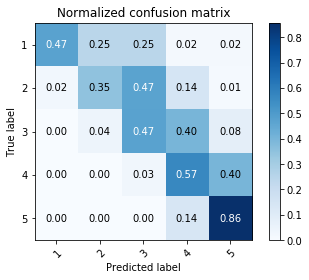

In [17]:
helpers.plot_confusion_matrix(y_test, 
                      vot.predict(test_feature_matrix), 
                      ['1', '2', '3', '4', '5'])

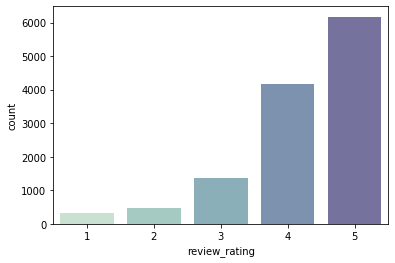

In [18]:
sns.countplot(x=y_train, palette = sns.cubehelix_palette(8, start=1, rot=-.75))

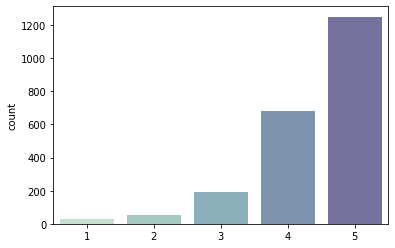

In [19]:
sns.countplot(x=vot.predict(test_feature_matrix), palette = sns.cubehelix_palette(8, start=1, rot=-.75))

It is clear that the model is pretty accurate, for when it predicts the star rating wrong, it is generally within one star of the correct answer, a vast improvement from the baseline model.

The predictions also have about the same distribution of star ratings as the training data, which suggests that this model is pretty accurate, and doesn't just predict all of the test data to be in the most frequent category.

When comparing this model with the baseline model, we see an accuracy improvement of almost 40%, which is a huge improvement. Furthermore, when considering the fact that when the model using nlp-primitives is wrong, it is a lot closer to the right answer than the original model, we can see that using these primitives improves the model further beyond the 40% increase in raw accuracy.

## Step 6. Next Steps

This is an end-to-end example of going from raw text data to a machine learning model with Natural Language Processing Primitives. However, in a problem such as this one, ideally there would be more data available, especially pertaining to the customer who wrote each review. 

Featuretools makes it easy to deal with relational datasets, and so this new extra data would be relatively simple to add into the pipeline, just requiring the addition of a new entity to the entityset, and a recalculation of DFS and the following steps with the newly modified entityset.

<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact/).